In [1]:
# -*- coding: utf-8 -*-

"""
This software is part of GPU Ocean. 
Copyright (C) 2019 SINTEF Digital

This python program is used to set up and run a data-assimilation 
and drift trajectory forecasting experiment.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""


import sys, os, datetime, time, shutil
from importlib import reload 
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gridspec

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

current_dir = os.getcwd()

if os.path.isdir(os.path.abspath(os.path.join(current_dir, '../../SWESimulators'))):
        sys.path.insert(0, os.path.abspath(os.path.join(current_dir, '../../')))

from SWESimulators import IPythonMagic
from SWESimulators import BaseOceanStateEnsemble, OceanNoiseEnsemble, CDKLM16 
from SWESimulators import Common
from SWESimulators import DataAssimilationUtils as dautils



In [2]:
%cuda_context_handler gpu_ctx
%setup_logging --out enkf_gpu.log --file_level 15

Console logger using level INFO
File logger using level Level 15 to enkf_gpu.log
Python version 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 01:53:57) [MSC v.1916 64 bit (AMD64)]


# Set up an instance 

OceanNoiseEnsemble using CDKLM16-Simulators

In [3]:
# DEFINE PARAMETERS

sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 60, "ny": 60,
    "dx": 4.0, "dy": 4.0,
    "dt": 0.05,
    "g": 9.81,
    "f": 0.05,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "rk_order": 2,
    "small_scale_perturbation_amplitude": None,
    "write_netcdf": False, 
    "small_scale_perturbation": True,
    "small_scale_perturbation_interpolation_factor": 3,
    "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
}

ghosts = np.array([2,2,2,2]) # north, east, south, west
validDomain = np.array([2,2,2,2])


dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])
dataShapeHi = (sim_args["ny"] + ghosts[0]+ghosts[2]+1, 
             sim_args["nx"] + ghosts[1]+ghosts[3]+1)

sim_args["eta0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hv0"] = np.zeros(dataShape, dtype=np.float32, order='C');
sim_args["hu0"] = np.zeros(dataShape, dtype=np.float32, order='C');
waterDepth = 10.0
sim_args["H"] = np.ones(dataShapeHi, dtype=np.float32, order='C')*waterDepth


if 'sim' in globals():
    sim.cleanUp()
if 'ensemble' in globals():
    ensemble.cleanUp()
if 'iewpfOcean' in globals():
    iewpfOcean.cleanUp()
    
sim_args["small_scale_perturbation_amplitude"] = np.sqrt(sim_args["dt"])*0.5*sim_args["f"]/(sim_args["g"]*waterDepth)
sim_args["small_scale_perturbation_amplitude"] *= sim_args["small_scale_perturbation_interpolation_factor"]
print ("q0: ", sim_args["small_scale_perturbation_amplitude"])
print ("[f, g, H, dt]", [sim_args["f"], sim_args["g"], waterDepth, sim_args["dt"]])
print ("(nx, ny): ", (sim_args["nx"], sim_args["ny"]))

reload(CDKLM16)
reload(BaseOceanStateEnsemble)
reload(OceanNoiseEnsemble)
reload(dautils)

sim = CDKLM16.CDKLM16(**sim_args)
sim.perturbState(q0_scale=100)
    
ensemble_args = {
    "gpu_ctx": gpu_ctx,
    "numParticles": 25,
    "num_drifters": 1,
    "sim": sim,
    "observation_type": dautils.ObservationType.DirectUnderlyingFlow,
    "observation_variance": 0.02**2,
    "initialization_variance_factor_ocean_field" : 25.0
}

ensemble = OceanNoiseEnsemble.OceanNoiseEnsemble(**ensemble_args)

max_dt = ensemble.findLargestPossibleTimeStep()
print ("max_dt: ", max_dt)

print ("Ready!")

q0:  0.00017095320928897472
[f, g, H, dt] [0.05, 9.81, 10.0, 0.05]
(nx, ny):  (60, 60)
max_dt:  0.0878535807132721
Ready!


# Run Simulation and perform DA at Observation Times

In [4]:
sys.path.insert(0, os.getcwd())
import EnKFOcean
reload(EnKFOcean)

EnKFOcean = EnKFOcean.EnKFOcean(ensemble)

t_obs = [5,10,15,20,25]
t_max = 40

t_steps = 0.5

t = 0
idx_obs = 0


while t < t_max:
    print("t = ", t)
    
    ensemble.step(t)

    if t==t_obs[idx_obs]:
        print("Enter EnKF for observation time t = ", t)

        EnKFOcean.EnKF()

        if idx_obs < len(t_obs)-1:
            idx_obs += 1

    ensemble.getEnsembleVarAndRMSEUnderDrifter(t)
    t = t + t_steps

print("Ready!")

t =  0
t =  0.5
t =  1.0
t =  1.5
t =  2.0
t =  2.5
t =  3.0
t =  3.5
t =  4.0
t =  4.5
t =  5.0
Enter EnKF for observation time t =  5.0
t =  5.5
t =  6.0
t =  6.5
t =  7.0
t =  7.5
t =  8.0
t =  8.5
t =  9.0
t =  9.5
t =  10.0
Enter EnKF for observation time t =  10.0
t =  10.5
t =  11.0
t =  11.5
t =  12.0
t =  12.5
t =  13.0
t =  13.5
t =  14.0
t =  14.5
t =  15.0
Enter EnKF for observation time t =  15.0
t =  15.5
t =  16.0
t =  16.5
t =  17.0
t =  17.5
t =  18.0
t =  18.5
t =  19.0
t =  19.5
t =  20.0
Enter EnKF for observation time t =  20.0
t =  20.5
t =  21.0
t =  21.5
t =  22.0
t =  22.5
t =  23.0
t =  23.5
t =  24.0
t =  24.5
t =  25.0
Enter EnKF for observation time t =  25.0
t =  25.5
t =  26.0
t =  26.5
t =  27.0
t =  27.5
t =  28.0
t =  28.5
t =  29.0
t =  29.5
t =  30.0
t =  30.5
t =  31.0
t =  31.5
t =  32.0
t =  32.5
t =  33.0
t =  33.5
t =  34.0
t =  34.5
t =  35.0
t =  35.5
t =  36.0
t =  36.5
t =  37.0
t =  37.5
t =  38.0
t =  38.5
t =  39.0
t =  39.5
Ready!


# Plot RMSE Analysis

(0.0, 10.0)

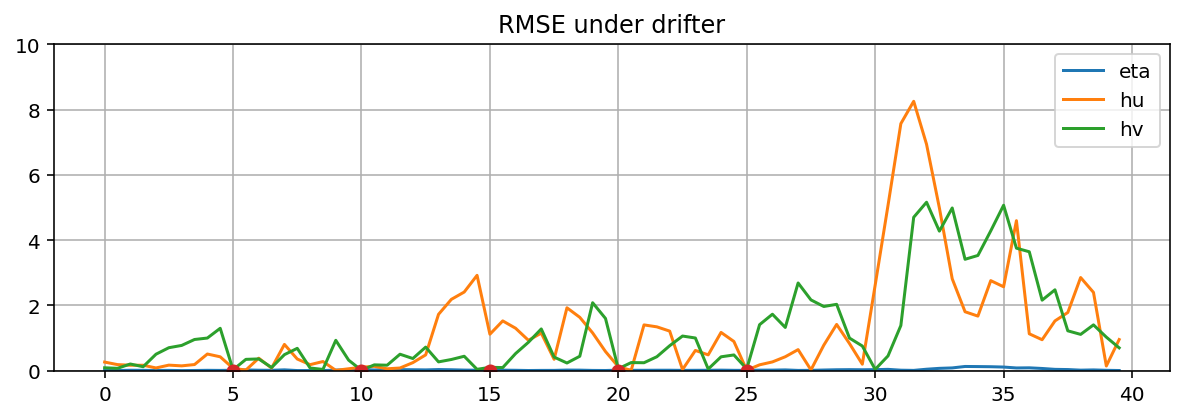

In [7]:
fig = plt.figure(figsize=(10,3))
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_eta, label='eta')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hu,  label='hu')
plt.plot(ensemble.tArray, ensemble.rmseUnderDrifter_hv,  label='hv')
plt.plot(t_obs, 0.0*np.ones_like(t_obs), 'o')
plt.title("RMSE under drifter")
plt.legend(loc=0)
plt.grid()
plt.ylim([0, 10])